In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import ast
from scipy.stats import norm, truncnorm
from sklearn.preprocessing import RobustScaler,MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score


In [3]:
def categorias_atributos(df,atributos,categorias):
    '''Agrega los id's de los atributos y categoría correspondientes a cada negocio'''
    df_merged = pd.merge(df, atributos[['id', 'atributo_id']], how='left', on='id')
    # Agrupar por 'id' y generar la lista de atributos
    df_merged_list = df_merged.groupby('id')['atributo_id'].apply(list).reset_index()
    # Unir esta información con el dataframe original de 'negocios'
    df_medio = pd.merge(df, df_merged_list, how='left', on='id')
    # Unir la tabla de negocios con la tabla intermedia para obtener los atributos
    df_merged2 = pd.merge(df_medio, categorias[['id', 'category_id']], how='left', on='id')
    # Agrupar por 'id' y generar la lista de atributos
    df_merged_list2 = df_merged2.groupby('id')['category_id'].apply(list).reset_index()
    # Unir esta información con el dataframe original de 'negocios'
    df_final = pd.merge(df_medio, df_merged_list2, how='left', on='id')    
    return df_final

def atributos_destacados(df,atributos):
    '''Devuelve los atributos que mas se repiten ordenados de amyor a menor '''
    # Expandimos la lista de atributo_id para obtener el nombre del atributo correspondiente
    df['atributo_nombres'] = df['atributo_id'].apply(lambda x: [atributos[atributos['atributo_id'] == id_]['atributo'].values[0] for id_ in x])
    # Luego, unimos todos los atributos de todas las filas
    todos_los_atributos = df['atributo_nombres'].explode().tolist()
    # Contamos las frecuencias de los atributos
    frecuencia_atributos = pd.Series(todos_los_atributos).value_counts()
    atributos_ordenados = frecuencia_atributos.index.tolist()
    return atributos_ordenados

def preparacion_dataframe(df,reviews,ciudades):
    # Crear la columna 'review_buena_vader' según las condiciones dadas
    reviews['review_buena_vader'] = reviews.apply(
        lambda row: 1 if row['vader_score'] > 0 else (
            0 if row['vader_score'] < 0 else (
                1 if row['rating'] >= 4 else 0
            )
        ), axis=1)
    # Crear la columna 'review_buena_textblob' según las condiciones dadas
    reviews['review_buena_textblob'] = reviews.apply(
        lambda row: 1 if row['textblob_score'] > 0 else (
            0 if row['textblob_score'] < 0 else (
                1 if row['rating'] >= 4 else 0
            )
        ), axis=1)
    # Contamos las reseñas positivas (donde 'review_buena_vader' es 1)
    reviews_positivas = reviews[reviews['review_buena_vader'] == 1].groupby('id').size().reset_index(name='reviews_positivas')
    # Contamos las reseñas negativas (donde 'review_buena_vader' es 0)
    reviews_negativas = reviews[reviews['review_buena_vader'] == 0].groupby('id').size().reset_index(name='reviews_negativas')
    # Unimos los resultados con el DataFrame original en función de 'gmap_id'
    reviews = reviews.merge(reviews_positivas, on='id', how='left')
    reviews = reviews.merge(reviews_negativas, on='id', how='left')
    reviews["reviews_positivas"]=reviews["reviews_positivas"].fillna(0)
    reviews["reviews_negativas"]=reviews["reviews_negativas"].fillna(0)
    reviews = reviews.sort_values(by='id', ascending=True)
    # Ponemos los nombres y la poblacion de las ciudades
    df = df.merge(ciudades[['city_id','city']], left_on='city_id', right_on='city_id', how='left')
    df_final = pd.merge(df, reviews[['id','reviews_positivas','reviews_negativas']], on='id', how='left')
    df_final = df_final.drop_duplicates(subset="id",ignore_index=True)
    return df_final

def redondeo_columna(df,columna):
    '''Redondea los valores float de la columna a enteros, pero los que se redondean en 0 los cambia por 1'''
    df[columna]=df[columna].round()
    df[columna] = df[columna].replace(0, 1)
    return df

def rellenado_con_distribucion(df,columna):
    '''Rellena los valores nulos de una columna numérica con números positivos aleatorios que sigan la distribución 
       que mejor se ajusta con los valores no nulos'''
    columna_non_null=df[columna].dropna()
    mu, std = norm.fit(columna_non_null)
    lower, upper = 0, np.inf
    truncnorm_dist = truncnorm((lower - mu) / std, (upper - mu) / std, loc=mu, scale=std)
    random_values = truncnorm_dist.rvs(size=df[columna].isnull().sum())
    random_values_series = pd.Series(random_values, index=df[df[columna].isnull()].index)
    df[columna] = df[columna].fillna(random_values_series)
    return df

**PREPARACIÓN DE LOS DATOS**

In [4]:
metadatos_inicial=pd.read_csv("./Base_de_datos_final/negocios.csv")
reviews=pd.read_csv("./Base_de_datos_final/reviews.csv")
ciudades=pd.read_csv("./Base_de_datos_final/ciudades.csv")
atributos=pd.read_csv('./Base_de_datos_final/atributos.csv')
categorias=pd.read_csv('./Base_de_datos_final/categorias.csv')
categorias_inter=pd.read_csv('./Base_de_datos_final/negocios_categorias.csv')
atributos_inter=pd.read_csv('./Base_de_datos_final/negocios_atributos.csv')

categorias=categorias.dropna(subset="category")

In [5]:
metadatos_med=categorias_atributos(metadatos_inicial,atributos_inter,categorias_inter)

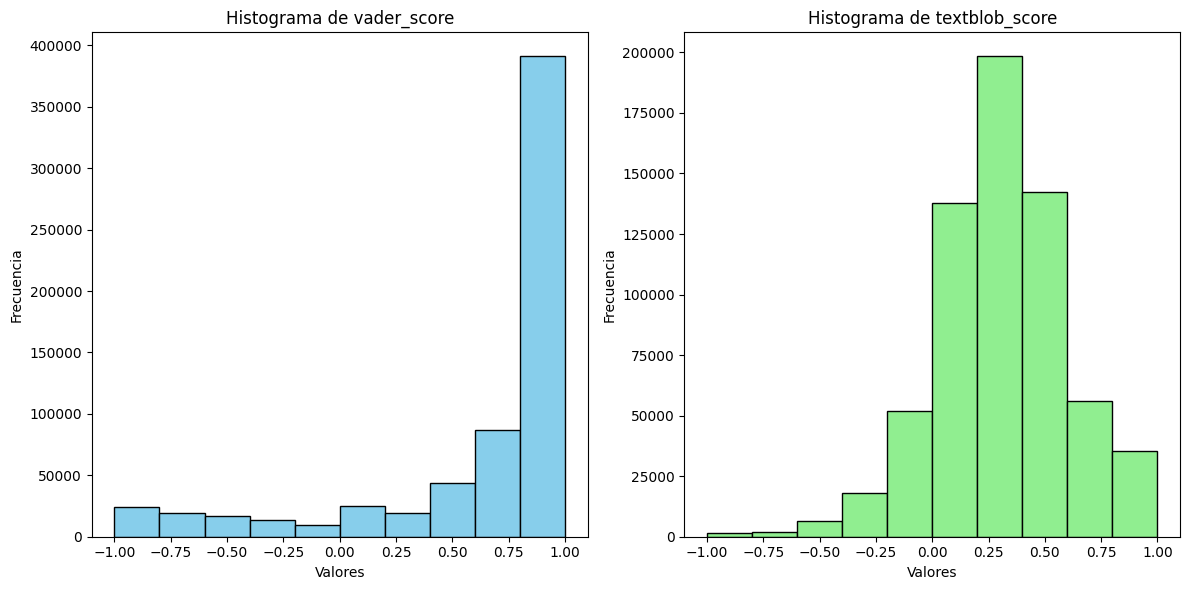

In [6]:
reviews_text=reviews[reviews["has_text"]!=0]

# Crear el bloque de histogramas
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Histograma para columna_1
axes[0].hist(reviews_text['vader_score'], bins=10, color='skyblue', edgecolor='black')
axes[0].set_title('Histograma de vader_score')
axes[0].set_xlabel('Valores')
axes[0].set_ylabel('Frecuencia')

# Histograma para columna_2
axes[1].hist(reviews_text['textblob_score'], bins=10, color='lightgreen', edgecolor='black')
axes[1].set_title('Histograma de textblob_score')
axes[1].set_xlabel('Valores')
axes[1].set_ylabel('Frecuencia')

# Ajustar el espacio entre los histogramas
plt.tight_layout()

# Mostrar los histogramas
plt.show()

In [7]:
print(f"Número de reviews totales: {reviews.shape[0]}")
print(f"Número de reviews totales con texto: {reviews_text.shape[0]}")

Número de reviews totales: 751917
Número de reviews totales con texto: 649952


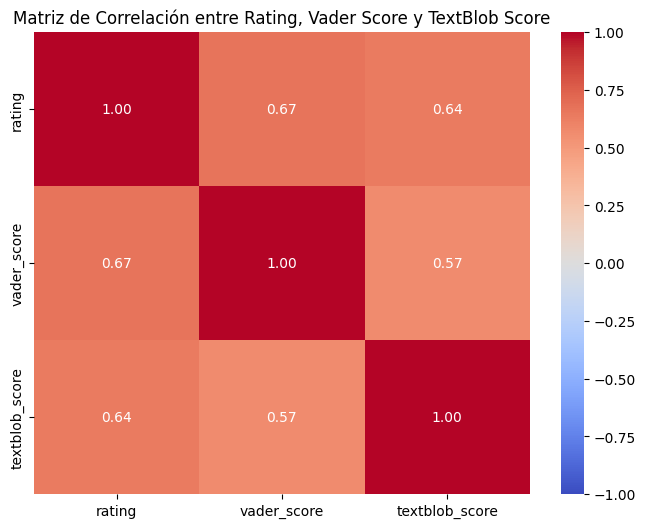

In [8]:
# Creamos un dtaframe solo con las reviews que tienen texto
reviews_text=reviews[reviews["has_text"]!=0]
# Calcular la matriz de correlación para las columnas 'rating', 'vader_score' y 'textblob_score'
correlation_matrix = reviews_text[['rating', 'vader_score', 'textblob_score']].corr()

# Crear un diagrama de calor para visualizar la matriz de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Matriz de Correlación entre Rating, Vader Score y TextBlob Score')
plt.show()

A las reviews que tengan ceros en las columnas `vader_score` y `textblob_score` las clasificaremos como buenas si `rating`>=4 y malas si `rating`<=3.

In [9]:
reviews1=reviews.copy()
# Crear la columna 'review_buena_vader' según las condiciones dadas
reviews1['review_buena_vader'] = reviews1.apply(
    lambda row: 1 if row['vader_score'] > 0 else (
        0 if row['vader_score'] < 0 else (
            1 if row['rating'] >= 4 else 0
        )
    ), axis=1)

# Crear la columna 'review_buena_textblob' según las condiciones dadas
reviews1['review_buena_textblob'] = reviews1.apply(
    lambda row: 1 if row['textblob_score'] > 0 else (
        0 if row['textblob_score'] < 0 else (
            1 if row['rating'] >= 4 else 0
        )
    ), axis=1)


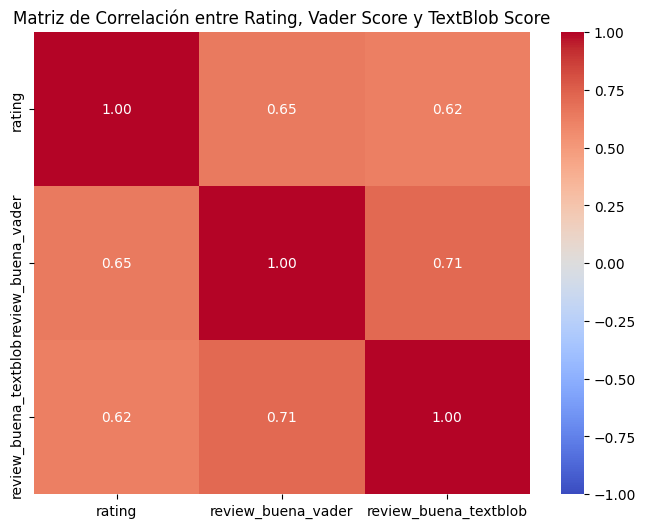

In [11]:
# Calcular la matriz de correlación para las columnas 'rating', 'vader_score' y 'textblob_score'
correlation_matrix = reviews1[['rating', 'review_buena_vader', 'review_buena_textblob']].corr()

# Crear un diagrama de calor para visualizar la matriz de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Matriz de Correlación entre Rating, Vader Score y TextBlob Score')
plt.show()

Podemos ver que la correlación entre el `raiting` y el la clasificación de "buena" y "mala" para las reviews aumento para ambos metodos de análisis de sentimiento. 

Quedémosnos por ahora con `vader` porque es la que tiene la mayor correlación con el rating

In [12]:
# Contamos las reseñas positivas (donde 'review_buena_vader' es 1)
reviews_positivas = reviews1[reviews1['review_buena_vader'] == 1].groupby('id').size().reset_index(name='reviews_positivas')

# Contamos las reseñas negativas (donde 'review_buena_vader' es 0)
reviews_negativas = reviews1[reviews1['review_buena_vader'] == 0].groupby('id').size().reset_index(name='reviews_negativas')

# Unimos los resultados con el DataFrame original en función de 'gmap_id'
reviews1 = reviews1.merge(reviews_positivas, on='id', how='left')
reviews1 = reviews1.merge(reviews_negativas, on='id', how='left')
reviews1["reviews_positivas"]=reviews1["reviews_positivas"].fillna(0)
reviews1["reviews_negativas"]=reviews1["reviews_negativas"].fillna(0)

reviews1 = reviews1.sort_values(by='id', ascending=True)

In [13]:
metadatos1 = pd.merge(metadatos_med, reviews1[['id','reviews_positivas','reviews_negativas']], on='id', how='left')
metadatos1=metadatos1.drop_duplicates(subset="id",ignore_index=True)
metadatos1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26325 entries, 0 to 26324
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 26325 non-null  object 
 1   name               26325 non-null  object 
 2   street_address     25984 non-null  object 
 3   postal_code        26325 non-null  int64  
 4   latitude           26325 non-null  float64
 5   longitude          26325 non-null  float64
 6   city_id            26325 non-null  int64  
 7   stars              26325 non-null  float64
 8   review_count       26325 non-null  int64  
 9   is_open            26325 non-null  int64  
 10  atributo_id        26325 non-null  object 
 11  category_id        26325 non-null  object 
 12  reviews_positivas  14430 non-null  float64
 13  reviews_negativas  14430 non-null  float64
dtypes: float64(5), int64(4), object(5)
memory usage: 2.8+ MB


No todos los restaurantes del dataframe de metadata estan en reviews. Esto deja un gran número de entradas vacías en las columnas de `reviews_positivas` y `reviews_negativas`. Lo que haremos es ver la distribución gaussiana que mejor se ajuste a las entradas quu no sean vacías. Luego rellenaremos estas últimas con valores aleatorios siguiendo esas distribuciones. 

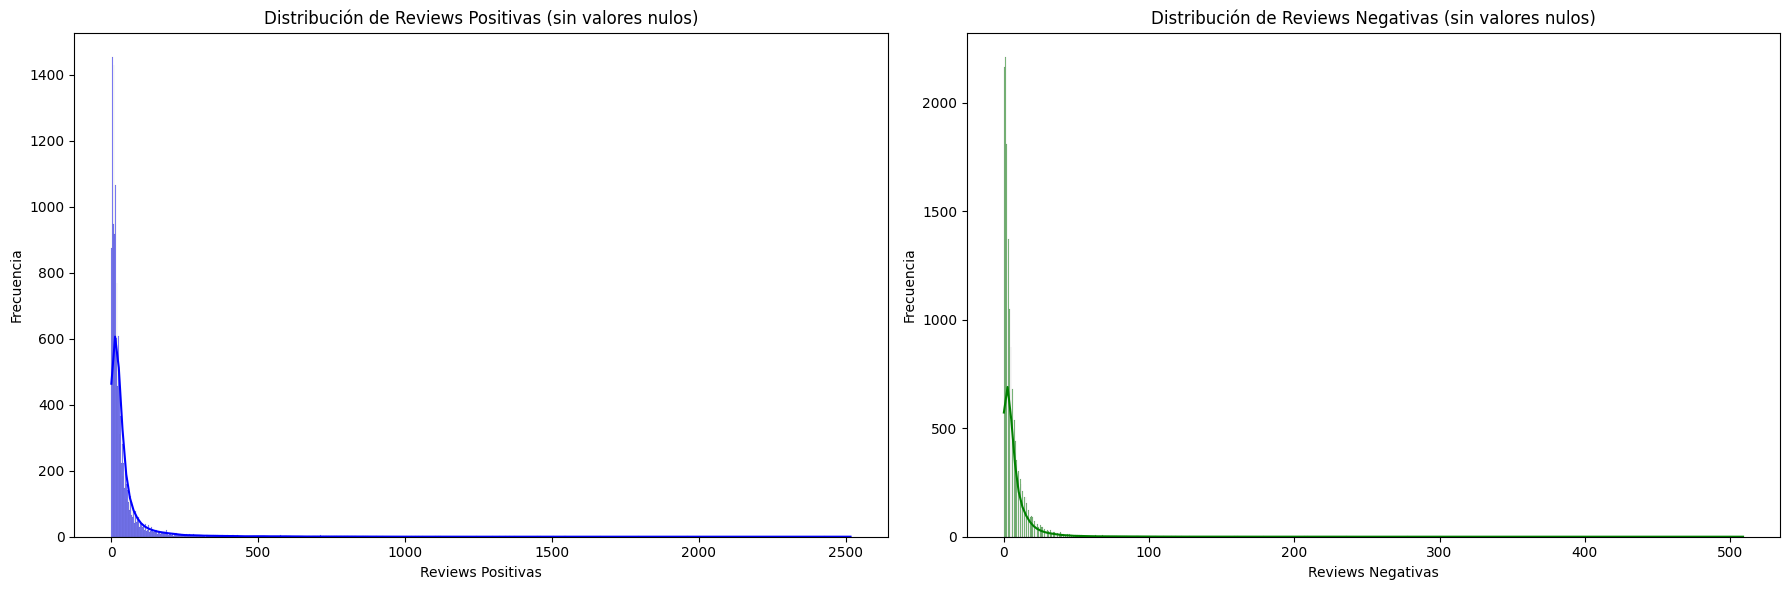

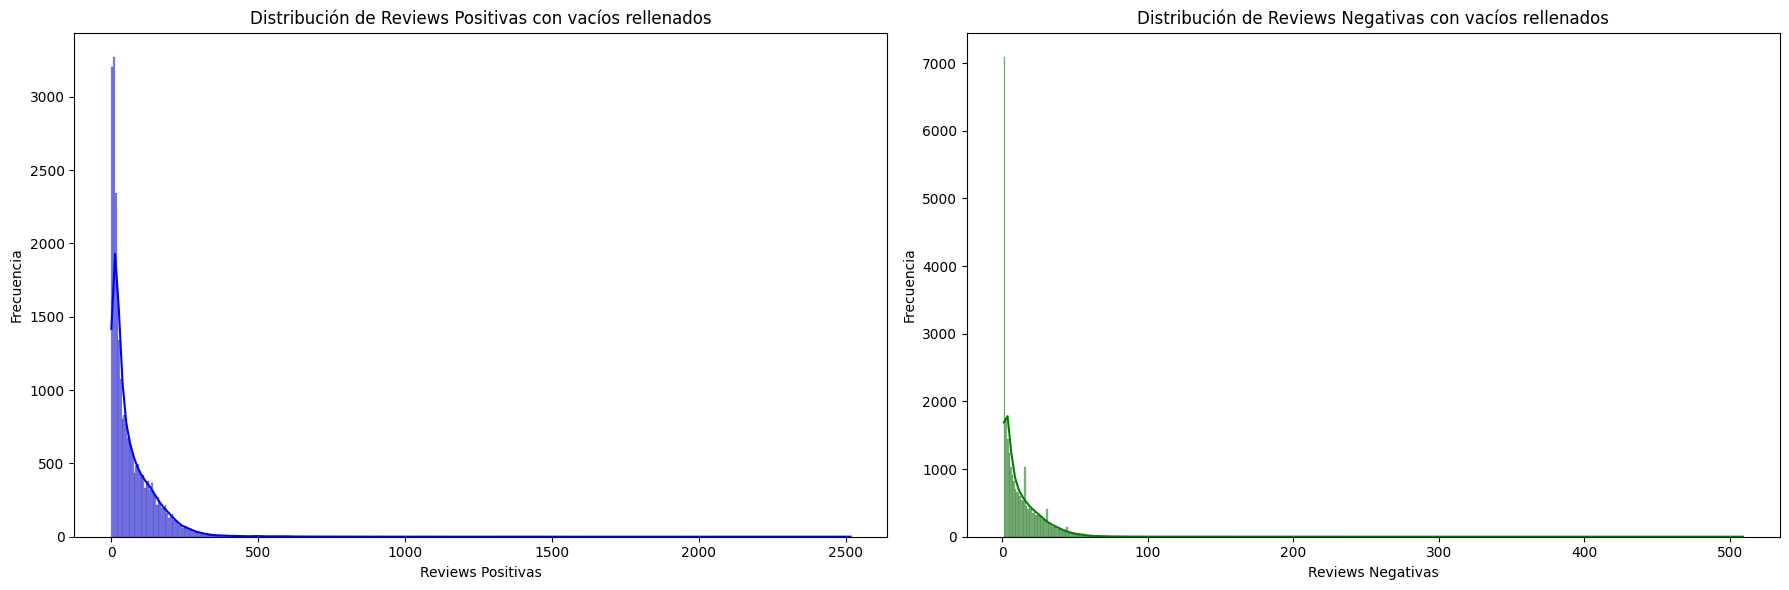

In [14]:
reviews_positivas_non_null = metadatos1['reviews_positivas'].dropna()
reviews_negativas_non_null = metadatos1['reviews_negativas'].dropna()

# Visualizar la distribución de los valores no nulos
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 fila, 3 columnas

sns.histplot(reviews_positivas_non_null.dropna(), kde=True, ax=axes[0], color='blue')
axes[0].set_title('Distribución de Reviews Positivas (sin valores nulos)')
axes[0].set_xlabel('Reviews Positivas')
axes[0].set_ylabel('Frecuencia')

sns.histplot(reviews_negativas_non_null, kde=True, ax=axes[1], color='green')
axes[1].set_title('Distribución de Reviews Negativas (sin valores nulos)')
axes[1].set_xlabel('Reviews Negativas')
axes[1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

metadatos1=rellenado_con_distribucion(metadatos1,'reviews_positivas')
metadatos1=rellenado_con_distribucion(metadatos1,'reviews_negativas')
metadatos1=redondeo_columna(metadatos1,['reviews_positivas','reviews_negativas'])

# Visualizar la distribución de los valores
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 fila, 3 columnas

sns.histplot(metadatos1['reviews_positivas'], kde=True, ax=axes[0], color='blue')
axes[0].set_title('Distribución de Reviews Positivas con vacíos rellenados')
axes[0].set_xlabel('Reviews Positivas')
axes[0].set_ylabel('Frecuencia')

sns.histplot(metadatos1['reviews_negativas'], kde=True, ax=axes[1], color='green')
axes[1].set_title('Distribución de Reviews Negativas con vacíos rellenados')
axes[1].set_xlabel('Reviews Negativas')
axes[1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

Como se puede ver, las distribuciones resultantes de rellenar las entradas vacías tienen las mismas características de las originales, solo que son mucho más pobladas. Ahora creamos una columna `numero_reviews` que sea la suma de ambas columnas.

In [ ]:
metadatos1["numero_reviews"]=metadatos1["reviews_positivas"]+metadatos1["reviews_negativas"]

In [ ]:
metadatos1 = metadatos1.merge(ciudades[['city_id','city', 'population']], left_on='city_id', right_on='city_id', how='left')

In [17]:
metadatos1 = metadatos1.sort_values(by='city', ascending=True)
metadatos1=metadatos1.reset_index(drop=True)

Guardamos el dataframe en el archivo `metadatos_ML.csv`

In [19]:
metadatos1.to_csv('./Modelo_ML/metadatos_ML.csv',index=False)

**FUNCIONES PARA ARMAR LAS CLUMNAS PARA ENTRENAR LOS MODELOS**

In [4]:
def cantidad_competencia(id_categoria,df):

    variables_en_juego=['population','numero_restaurantes']
    # Filtramos por categorias
    df_filtrado=df[df['category_id'].apply(lambda x: id_categoria in x)]
    # Calculamos columnas para la fórmula 
    numero_restaurantes = df_filtrado.groupby('city_id').size()
    df_filtrado["numero_restaurantes"]=df_filtrado['city_id'].map(numero_restaurantes)
    df_filtrado=df_filtrado.drop_duplicates(subset="city_id",ignore_index=True)
    df_final=df_filtrado[variables_en_juego]
    noise = np.random.normal(0, 0.1, df_final.shape)  # media 0, desviación estándar 0.1
    df2=df_final + noise
    df3=df_final.copy()
    df3[variables_en_juego]=np.log1p(df_final[variables_en_juego])
    df4=df_final.copy()
    df4[variables_en_juego]=np.sqrt(df_final[variables_en_juego])
    df5=df4 + noise
    df6=df3 + noise
    df7=df_final.copy()
    df7[variables_en_juego]=(df_final[variables_en_juego])**(1/4)
    df8=df7 + noise
    df9=df_final.copy()
    df9[variables_en_juego]=(df_final[variables_en_juego])**(1/8)
    df10=df9 + noise
    df11=df_final.copy()
    df11[variables_en_juego]=(df_final[variables_en_juego])*4
    df12=df9 + noise
    df_final=pd.concat([df_final,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12],axis=0, ignore_index=True)    
    df_final["P_h"]=(df_final["population"]/df_final["numero_restaurantes"])
    scaler = MinMaxScaler()
    df_final[["P_h"]] = scaler.fit_transform(df_final[["P_h"]])
    return df_final

def calidad_competencia(id_categoria,df):

    variables_en_juego=['reviews_positivas','reviews_negativas','numero_reviews','stars']
    # Filtramos por categorias
    df_filtrado=df[df['category_id'].apply(lambda x: id_categoria in x)]
    # Calculamos columnas para la fórmula 
    numero_restaurantes = df_filtrado.groupby('city_id').size()
    df_filtrado["numero_restaurantes"]=df_filtrado['city_id'].map(numero_restaurantes)
    df_final=df_filtrado[variables_en_juego]
    noise = np.random.normal(0, 0.1, df_final.shape)  # media 0, desviación estándar 0.1
    df2=df_final + noise
    df3=df_final.copy()
    df3[variables_en_juego]=np.log1p(df_final[variables_en_juego])
    df4=df_final.copy()
    df4[variables_en_juego]=np.sqrt(df_final[variables_en_juego])
    df5=df4 + noise
    df6=df3 + noise
    df_final=pd.concat([df_final,df2,df3,df4,df5,df6],axis=0, ignore_index=True)
    scaler = MinMaxScaler()
    df_final["P_{r,i}"]=(df_final['reviews_positivas']/df_final['reviews_negativas'])*df_final['numero_reviews']
    df_final["P_{c,i}"]=df_final['stars']*df_final['numero_reviews']
    df_final[['P_{r,i}']] = (df_final[['P_{r,i}']]**(2/3))*3
    #df_filtrado[['P_{r,i}','P_{c,i}']] = scaler.fit_transform(df_filtrado[['P_{r,i}','P_{c,i}']])
    df_final['P_C']=df_final['P_{r,i}']+df_final['P_{c,i}']
    df_final['1/P_C']=df_final['P_C']**(-1)
    df_final[['1/P_C']] = scaler.fit_transform(df_final[['1/P_C']])
    return df_final

Acá se arman los datos de entrenamiento y los de testeo 

In [ ]:
metadatos1['category_id']=metadatos1['category_id'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
categorias_list=[i for i in range(1,categorias.shape[0]+1)]
#dfs_categorias = [cantidad_competencia(categoria,metadatos1) for categoria in categorias_list]
dfs_categorias = [calidad_competencia(categoria,metadatos1) for categoria in categorias_list]
for i in range(1,len(dfs_categorias)+1):
    dfs_categorias[i-1]['category_id']=i

#X=[dfs_categorias[i][['population', 'numero_restaurantes']] for i in range(len(dfs_categorias))]
X=[dfs_categorias[i][['reviews_positivas','reviews_negativas','stars']] for i in range(len(dfs_categorias))]

#y=[dfs_categorias[i]['P_h'] for i in range(len(dfs_categorias))]
y=[dfs_categorias[i]['1/P_C'] for i in range(len(dfs_categorias))]

# Filtrar los dataframes que tienen más de una muestra
X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []

for i in range(len(dfs_categorias)):
    if len(X[i]) > 1:  # Solo dividir si hay más de 1 muestra
        X_temp, X_temp_test, y_temp, y_temp_test = train_test_split(X[i], y[i], test_size=0.2, random_state=42)
        X_train_list.append(X_temp)
        X_test_list.append(X_temp_test)
        y_train_list.append(y_temp)
        y_test_list.append(y_temp_test)
    else:
        print(f"Categoria '{categorias[i]}' tiene solo una muestra. No se puede dividir.")

X_train=pd.concat([df for df in X_train_list],axis=0, ignore_index=True)
X_test=pd.concat([df for df in X_test_list],axis=0, ignore_index=True)
y_train=pd.concat([df for df in y_train_list],axis=0, ignore_index=True)
y_test=pd.concat([df for df in y_test_list],axis=0, ignore_index=True)


scaler = MinMaxScaler()
#variables=['population', 'numero_restaurantes']
variables=['reviews_positivas','reviews_negativas','stars']
X_train[variables]=scaler.fit_transform(X_train[variables])
X_test[variables]=scaler.fit_transform(X_test[variables])



**PRUEBA DE LOS HIPERPARÁMETROS**

Cambio el `numero de neuronas por capas` para ver como cambia el Root Mean Squared Error

In [ ]:
# Lista para almacenar los RMSE calculados
rmse_train_values = []
rmse_test_values = []
r2=[]
neurons_range = [4, 8, 16, 32, 64, 128, 256]

# Configurar EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss',  # Monitorear la pérdida de validación
                               patience=5,          # Número de épocas sin mejora antes de detener
                               restore_best_weights=True,  # Restaurar los pesos del mejor modelo
                               verbose=1)            # Imprimir información sobre el EarlyStopping

for i in neurons_range:
    # Crear el modelo
    model = Sequential()
    # Capa de entrada
    model.add(Dense(3, input_dim=X_train.shape[1], activation='relu'))
    # Capa oculta
    model.add(Dense(i, activation='relu'))
    model.add(Dense(i, activation='relu'))
    model.add(Dense(i, activation='relu'))
    # Capa de salida (un solo valor para el coeficiente phi)
    model.add(Dense(1, activation='linear'))
    # Compilar el modelo
    model.compile(optimizer='Nadam', loss='mean_squared_error')

    # Entrenar el modelo con EarlyStopping
    history = model.fit(X_train, y_train, epochs=100, batch_size=100, validation_data=(X_test, y_test), 
                        callbacks=[early_stopping])
    # Realizar predicciones
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Asegúrate de que ambos son vectores 1D
    if len(y_pred_train.shape) > 1:
        y_pred_train = y_pred_train.flatten()

    if len(y_train.shape) > 1:
        y_train = y_train.flatten()

    if len(y_pred_train.shape) > 1:
        y_pred_train = y_pred_test.flatten()

    if len(y_test.shape) > 1:
        y_test = y_test.flatten()

    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    r2_i=r2_score(y_test, y_pred_test)

    rmse_train_values.append(rmse_train)
    rmse_test_values.append(rmse_test)
    r2.append(r2_i)

# Graficar los resultados
plt.plot(neurons_range, rmse_train_values, marker='o', color='b', label='Entrenamiento')
plt.plot(neurons_range, rmse_test_values, marker='o', color='r', label='Prueba')
plt.title('RMSE vs Número de Neuronas en la Capa Oculta')
plt.xlabel('Número de Neuronas en la Capa Oculta')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.grid(True)
plt.legend()
plt.show()

plt.plot(neurons_range, r2, marker='o', color='r', label='Prueba')
plt.title('RMSE vs Número de Neuronas en la Capa Oculta')
plt.xlabel('Número de Neuronas en la Capa Oculta')
plt.ylabel('r^2 de los datos de testeo')
plt.grid(True)
plt.legend()
plt.show()

# Mostrar los RMSE correspondientes
print(pd.DataFrame({"Neuronas:": neurons_range,
                    "RMSE en Prueba:": rmse_test_values,
                    "r2 testeo":r2},))


Cambio el `numero de epochs` para ver como cambia el Root Mean Squared Error

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',  # Monitorear la pérdida de validación
                               patience=5,          # Número de épocas sin mejora antes de detener
                               restore_best_weights=True,  # Restaurar los pesos del mejor modelo
                               verbose=1)            # Imprimir información sobre el EarlyStopping

# Lista para almacenar los RMSE calculados
rmse_train_values = []
rmse_test_values = []
r2=[]
numero_etapas = [20,25, 50, 75, 100, 125, 150, 175,200] 
for i in  numero_etapas:
    # Crear el modelo
    model = Sequential()
    # Capa de entrada
    model.add(Dense(3, input_dim=X_train.shape[1], activation='relu'))
    # Capa oculta
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    # Capa de salida (un solo valor para el coeficiente phi)
    model.add(Dense(1, activation='linear'))
    # Compilar el modelo
    model.compile(optimizer='Nadam', loss='mean_squared_error')
    # Entrenar el modelo
    history = model.fit(X_train, y_train, epochs=i, batch_size=100, validation_data=(X_test, y_test), 
                        callbacks=[early_stopping])
    # Realizar predicciones
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    # Asegúrate de que ambos son vectores 1D
    if len(y_pred_train.shape) > 1:
        y_pred_train = y_pred_train.flatten()

    if len(y_train.shape) > 1:
        y_train = y_train.flatten()

    if len(y_pred_train.shape) > 1:
        y_pred_train = y_pred_test.flatten()

    if len(y_test.shape) > 1:
        y_test = y_test.flatten()

    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    r2_i=r2_score(y_test, y_pred_test)

    rmse_train_values.append(rmse_train)
    rmse_test_values.append(rmse_test)
    r2.append(r2_i)

# Graficar los resultados
plt.plot(numero_etapas, rmse_train_values, marker='o', color='b', label='Entrenamiento')
plt.plot(numero_etapas, rmse_test_values, marker='o', color='r', label='Prueba')
plt.title('RMSE vs Número de Neuronas en la Capa Oculta')
plt.xlabel('Número de Neuronas en la Capa Oculta')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.grid(True)
plt.legend()
plt.show()

plt.plot(numero_etapas, r2, marker='o', color='r', label='Prueba')
plt.title('RMSE vs Número de Neuronas en la Capa Oculta')
plt.xlabel('Número de Neuronas en la Capa Oculta')
plt.ylabel('r^2 de los datos de testeo')
plt.grid(True)
plt.legend()
plt.show()

# Mostrar los RMSE correspondientes
print(pd.DataFrame({"Neuronas:": numero_etapas,
                    "RMSE en Prueba:": rmse_test_values,
                    "r2 testeo":r2},))

Cambio el `batch_size` para ver como cambia el Root Mean Squared Error

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',  # Monitorear la pérdida de validación
                               patience=5,          # Número de épocas sin mejora antes de detener
                               restore_best_weights=True,  # Restaurar los pesos del mejor modelo
                               verbose=1)            # Imprimir información sobre el EarlyStopping

# Lista para almacenar los RMSE calculados
rmse_train_values = []
rmse_test_values = []
r2=[]
batch_size = [25, 50, 75, 100, 125, 150, 175,200] 
for i in  batch_size:
    # Crear el modelo
    model = Sequential()

    # Capa de entrada
    model.add(Dense(3, input_dim=X_train.shape[1], activation='relu'))
    # Capa oculta
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))

    # Capa de salida (un solo valor para el coeficiente phi)
    model.add(Dense(1, activation='linear'))

    # Compilar el modelo
    #model.compile(optimizer='adam', loss='mean_squared_error')
    #model.compile(optimizer='RMSprop', loss='mean_squared_error')
    model.compile(optimizer='Nadam', loss='mean_squared_error')

    # Entrenar el modelo
    history = model.fit(X_train, y_train, epochs=125, batch_size=i, validation_data=(X_test, y_test), 
                        callbacks=[early_stopping])

    # Realizar predicciones
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)


    # Asegúrate de que ambos son vectores 1D
    if len(y_pred_train.shape) > 1:
        y_pred_train = y_pred_train.flatten()

    if len(y_train.shape) > 1:
        y_train = y_train.flatten()

    if len(y_pred_train.shape) > 1:
        y_pred_train = y_pred_test.flatten()

    if len(y_test.shape) > 1:
        y_test = y_test.flatten()

    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    r2_i=r2_score(y_test, y_pred_test)

    rmse_train_values.append(rmse_train)
    rmse_test_values.append(rmse_test)
    r2.append(r2_i)

# Graficar los resultados
plt.plot(batch_size, rmse_train_values, marker='o', color='b', label='Entrenamiento')
plt.plot(batch_size, rmse_test_values, marker='o', color='r', label='Prueba')
plt.title('RMSE vs Número de Neuronas en la Capa Oculta')
plt.xlabel('Número de Neuronas en la Capa Oculta')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.grid(True)
plt.legend()
plt.show()

plt.plot(batch_size, r2, marker='o', color='r', label='Prueba')
plt.title('RMSE vs Número de Neuronas en la Capa Oculta')
plt.xlabel('Número de Neuronas en la Capa Oculta')
plt.ylabel('r^2 de los datos de testeo')
plt.grid(True)
plt.legend()
plt.show()

# Mostrar los RMSE correspondientes
print(pd.DataFrame({"Neuronas:": batch_size,
                    "RMSE en Prueba:": rmse_test_values,
                    "r2 testeo":r2},))


Cambio el `optimizer` para ver como cambia el Root Mean Squared Error

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',  # Monitorear la pérdida de validación
                               patience=5,          # Número de épocas sin mejora antes de detener
                               restore_best_weights=True,  # Restaurar los pesos del mejor modelo
                               verbose=1)            # Imprimir información sobre el EarlyStopping

# Crear el modelo
model1 = Sequential()
model1.add(Dense(3, input_dim=X_train.shape[1], activation='relu'))
model1.add(Dense(128, activation='relu'))
model1.add(Dense(128, activation='relu'))
model1.add(Dense(128, activation='relu'))
model1.add(Dense(1, activation='linear'))

model1.compile(optimizer='Nadam', loss='mean_squared_error')
history = model1.fit(X_train, y_train, epochs=125, batch_size=200, validation_data=(X_test, y_test), 
                        callbacks=[early_stopping])
y_pred_train = model1.predict(X_train)
y_pred_test = model1.predict(X_test)

if len(y_pred_train.shape) > 1:
     y_pred_train = y_pred_train.flatten()
if len(y_train.shape) > 1:
    y_train = y_train.flatten()
if len(y_pred_train.shape) > 1:
    y_pred_train = y_pred_test.flatten()
if len(y_test.shape) > 1:
    y_test = y_test.flatten()

mse_train_Nadam = mean_squared_error(y_train, y_pred_train)
rmse_train_Nadam = np.sqrt(mse_train_Nadam)
mse_test_Nadam = mean_squared_error(y_test, y_pred_test)
rmse_test_Nadam = np.sqrt(mse_test_Nadam)
r2_Nadam=r2_score(y_test, y_pred_test)
 

# Crear el modelo
model2 = Sequential()
model2.add(Dense(2, input_dim=X_train.shape[1], activation='relu'))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(1, activation='linear'))

model2.compile(optimizer='RMSprop', loss='mean_squared_error')
history = model2.fit(X_train, y_train, epochs=125, batch_size=100, validation_data=(X_test, y_test), 
                        callbacks=[early_stopping])
y_pred_train = model2.predict(X_train)
y_pred_test = model2.predict(X_test)

if len(y_pred_train.shape) > 1:
     y_pred_train = y_pred_train.flatten()
if len(y_train.shape) > 1:
    y_train = y_train.flatten()
if len(y_pred_train.shape) > 1:
    y_pred_train = y_pred_test.flatten()
if len(y_test.shape) > 1:
    y_test = y_test.flatten()

mse_train_RMSprop = mean_squared_error(y_train, y_pred_train)
rmse_train_RMSprop = np.sqrt(mse_train_RMSprop)
mse_test_RMSprop = mean_squared_error(y_test, y_pred_test)
rmse_test_RMSprop = np.sqrt(mse_test_RMSprop)
r2_RMSprop=r2_score(y_test, y_pred_test)

# Crear el modelo
model3 = Sequential()
model3.add(Dense(2, input_dim=X_train.shape[1], activation='relu'))
model3.add(Dense(128, activation='relu'))
model3.add(Dense(128, activation='relu'))
model3.add(Dense(128, activation='relu'))
model3.add(Dense(1, activation='linear'))


model3.compile(optimizer='adam', loss='mean_squared_error')
history = model3.fit(X_train, y_train, epochs=125, batch_size=100, validation_data=(X_test, y_test), 
                        callbacks=[early_stopping])
y_pred_train = model3.predict(X_train)
y_pred_test = model3.predict(X_test)

if len(y_pred_train.shape) > 1:
     y_pred_train = y_pred_train.flatten()
if len(y_train.shape) > 1:
    y_train = y_train.flatten()
if len(y_pred_train.shape) > 1:
    y_pred_train = y_pred_test.flatten()
if len(y_test.shape) > 1:
    y_test = y_test.flatten()

mse_train_adam = mean_squared_error(y_train, y_pred_train)
rmse_train_adam = np.sqrt(mse_train_adam)
mse_test_adam = mean_squared_error(y_test, y_pred_test)
rmse_test_adam = np.sqrt(mse_test_adam)
r2_adam=r2_score(y_test, y_pred_test)



print(' ')
print("Nadam:",'\n',
      f"- Entrenamiento: {rmse_train_Nadam}",'\n',
      f"- Testeo: {rmse_test_Nadam}",'\n',
      f"- r2: {r2_Nadam}")
print(' ')
print("RMSprop:",'\n',
      f"- Entrenamiento: {rmse_train_RMSprop}",'\n',
      f"- Testeo: {rmse_test_RMSprop}",'\n',
      f"- r2: {r2_RMSprop}")
print(' ')
print("adam:",'\n',
      f"- Entrenamiento: {rmse_train_adam}",'\n',
      f"- Testeo: {rmse_test_adam}",'\n',
      f"- r2: {r2_adam}")


Cambio el `número de capas ocultas` para ver como se modifica el Root Mean Square Error

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',  # Monitorear la pérdida de validación
                               patience=5,          # Número de épocas sin mejora antes de detener
                               restore_best_weights=True,  # Restaurar los pesos del mejor modelo
                               verbose=1)            # Imprimir información sobre el EarlyStopping

# Crear el modelo
model1 = Sequential()
model1.add(Dense(2, input_dim=X_train.shape[1], activation='relu'))
model1.add(Dense(128, activation='relu'))
model1.add(Dense(1, activation='linear'))

model1.compile(optimizer='Nadam', loss='mean_squared_error')
history = model1.fit(X_train, y_train, epochs=125, batch_size=200, validation_data=(X_test, y_test),  
                        callbacks=[early_stopping])
y_pred_train = model1.predict(X_train)
y_pred_test = model1.predict(X_test)

if len(y_pred_train.shape) > 1:
     y_pred_train = y_pred_train.flatten()
if len(y_train.shape) > 1:
    y_train = y_train.flatten()
if len(y_pred_train.shape) > 1:
    y_pred_train = y_pred_test.flatten()
if len(y_test.shape) > 1:
    y_test = y_test.flatten()

mse_train1 = mean_squared_error(y_train, y_pred_train)
rmse_train1 = np.sqrt(mse_train1)
mse_test1 = mean_squared_error(y_test, y_pred_test)
rmse_test1 = np.sqrt(mse_test1)
r2_1=r2_score(y_test, y_pred_test)

# Crear el modelo
model2 = Sequential()
model2.add(Dense(2, input_dim=X_train.shape[1], activation='relu'))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(1, activation='linear'))

model2.compile(optimizer='Nadam', loss='mean_squared_error')
history = model2.fit(X_train, y_train, epochs=125, batch_size=200, validation_data=(X_test, y_test),   
                        callbacks=[early_stopping])
y_pred_train = model2.predict(X_train)
y_pred_test = model2.predict(X_test)

if len(y_pred_train.shape) > 1:
     y_pred_train = y_pred_train.flatten()
if len(y_train.shape) > 1:
    y_train = y_train.flatten()
if len(y_pred_train.shape) > 1:
    y_pred_train = y_pred_test.flatten()
if len(y_test.shape) > 1:
    y_test = y_test.flatten()

mse_train2 = mean_squared_error(y_train, y_pred_train)
rmse_train2 = np.sqrt(mse_train2)
mse_test2 = mean_squared_error(y_test, y_pred_test)
rmse_test2 = np.sqrt(mse_test2)
r2_2=r2_score(y_test, y_pred_test)

# Crear el modelo
model3 = Sequential()
model3.add(Dense(2, input_dim=X_train.shape[1], activation='relu'))
model3.add(Dense(128, activation='relu'))
model3.add(Dense(128, activation='relu'))
model3.add(Dense(128, activation='relu'))
model3.add(Dense(1, activation='linear'))

model3.compile(optimizer='Nadam', loss='mean_squared_error')
history = model3.fit(X_train, y_train, epochs=125, batch_size=200, validation_data=(X_test, y_test),  
                        callbacks=[early_stopping])
y_pred_train = model3.predict(X_train)
y_pred_test = model3.predict(X_test)

if len(y_pred_train.shape) > 1:
     y_pred_train = y_pred_train.flatten()
if len(y_train.shape) > 1:
    y_train = y_train.flatten()
if len(y_pred_train.shape) > 1:
    y_pred_train = y_pred_test.flatten()
if len(y_test.shape) > 1:
    y_test = y_test.flatten()

mse_train3 = mean_squared_error(y_train, y_pred_train)
rmse_train3 = np.sqrt(mse_train3)
mse_test3 = mean_squared_error(y_test, y_pred_test)
rmse_test3 = np.sqrt(mse_test3)
r2_3=r2_score(y_test, y_pred_test)

# Crear el modelo
model4 = Sequential()
model4.add(Dense(2, input_dim=X_train.shape[1], activation='relu'))
model4.add(Dense(128, activation='relu'))
model4.add(Dense(128, activation='relu'))
model4.add(Dense(128, activation='relu'))
model4.add(Dense(128, activation='relu'))
model4.add(Dense(1, activation='linear'))

model4.compile(optimizer='Nadam', loss='mean_squared_error')
history = model4.fit(X_train, y_train, epochs=125, batch_size=200, validation_data=(X_test, y_test),   
                        callbacks=[early_stopping])
y_pred_train = model4.predict(X_train)
y_pred_test = model4.predict(X_test)

if len(y_pred_train.shape) > 1:
     y_pred_train = y_pred_train.flatten()
if len(y_train.shape) > 1:
    y_train = y_train.flatten()
if len(y_pred_train.shape) > 1:
    y_pred_train = y_pred_test.flatten()
if len(y_test.shape) > 1:
    y_test = y_test.flatten()

mse_train4 = mean_squared_error(y_train, y_pred_train)
rmse_train4 = np.sqrt(mse_train4)
mse_test4 = mean_squared_error(y_test, y_pred_test)
rmse_test4 = np.sqrt(mse_test4)
r2_4=r2_score(y_test, y_pred_test)

# Crear el modelo
model5 = Sequential()
model5.add(Dense(2, input_dim=X_train.shape[1], activation='relu'))
model5.add(Dense(128, activation='relu'))
model5.add(Dense(128, activation='relu'))
model5.add(Dense(128, activation='relu'))
model5.add(Dense(128, activation='relu'))
model5.add(Dense(128, activation='relu'))
model5.add(Dense(1, activation='linear'))

model5.compile(optimizer='Nadam', loss='mean_squared_error')
history = model5.fit(X_train, y_train, epochs=125, batch_size=200, validation_data=(X_test, y_test),   
                        callbacks=[early_stopping])
y_pred_train = model5.predict(X_train)
y_pred_test = model5.predict(X_test)

if len(y_pred_train.shape) > 1:
     y_pred_train = y_pred_train.flatten()
if len(y_train.shape) > 1:
    y_train = y_train.flatten()
if len(y_pred_train.shape) > 1:
    y_pred_train = y_pred_test.flatten()
if len(y_test.shape) > 1:
    y_test = y_test.flatten()

mse_train5 = mean_squared_error(y_train, y_pred_train)
rmse_train5 = np.sqrt(mse_train5)
mse_test5 = mean_squared_error(y_test, y_pred_test)
rmse_test5 = np.sqrt(mse_test5)
r2_5=r2_score(y_test, y_pred_test)

# Crear el modelo
model6 = Sequential()
model6.add(Dense(2, input_dim=X_train.shape[1], activation='relu'))
model6.add(Dense(128, activation='relu'))
model6.add(Dense(128, activation='relu'))
model6.add(Dense(128, activation='relu'))
model6.add(Dense(128, activation='relu'))
model6.add(Dense(128, activation='relu'))
model6.add(Dense(1, activation='linear'))

model6.compile(optimizer='Nadam', loss='mean_squared_error')
history = model6.fit(X_train, y_train, epochs=125, batch_size=200, validation_data=(X_test, y_test), 
                        callbacks=[early_stopping])
y_pred_train = model6.predict(X_train)
y_pred_test = model6.predict(X_test)

if len(y_pred_train.shape) > 1:
     y_pred_train = y_pred_train.flatten()
if len(y_train.shape) > 1:
    y_train = y_train.flatten()
if len(y_pred_train.shape) > 1:
    y_pred_train = y_pred_test.flatten()
if len(y_test.shape) > 1:
    y_test = y_test.flatten()

mse_train6 = mean_squared_error(y_train, y_pred_train)
rmse_train6 = np.sqrt(mse_train6)
mse_test6 = mean_squared_error(y_test, y_pred_test)
rmse_test6 = np.sqrt(mse_test6)
r2_6=r2_score(y_test, y_pred_test)


# Crear el modelo
model7 = Sequential()
model7.add(Dense(2, input_dim=X_train.shape[1], activation='relu'))
model7.add(Dense(128, activation='relu'))
model7.add(Dense(128, activation='relu'))
model7.add(Dense(128, activation='relu'))
model7.add(Dense(128, activation='relu'))
model7.add(Dense(128, activation='relu'))
model7.add(Dense(1, activation='linear'))

model7.compile(optimizer='Nadam', loss='mean_squared_error')
history = model7.fit(X_train, y_train, epochs=125, batch_size=200, validation_data=(X_test, y_test),   
                        callbacks=[early_stopping])
y_pred_train = model7.predict(X_train)
y_pred_test = model7.predict(X_test)

if len(y_pred_train.shape) > 1:
     y_pred_train = y_pred_train.flatten()
if len(y_train.shape) > 1:
    y_train = y_train.flatten()
if len(y_pred_train.shape) > 1:
    y_pred_train = y_pred_test.flatten()
if len(y_test.shape) > 1:
    y_test = y_test.flatten()

mse_train7 = mean_squared_error(y_train, y_pred_train)
rmse_train7 = np.sqrt(mse_train7)
mse_test7 = mean_squared_error(y_test, y_pred_test)
rmse_test7 = np.sqrt(mse_test7)
r2_7=r2_score(y_test, y_pred_test)

# Crear el modelo
model8 = Sequential()
model8.add(Dense(2, input_dim=X_train.shape[1], activation='relu'))
model8.add(Dense(128, activation='relu'))
model8.add(Dense(128, activation='relu'))
model8.add(Dense(128, activation='relu'))
model8.add(Dense(128, activation='relu'))
model8.add(Dense(128, activation='relu'))
model8.add(Dense(1, activation='linear'))

model8.compile(optimizer='Nadam', loss='mean_squared_error')
history = model8.fit(X_train, y_train, epochs=125, batch_size=200, validation_data=(X_test, y_test),  
                        callbacks=[early_stopping])
y_pred_train = model8.predict(X_train)
y_pred_test = model8.predict(X_test)

if len(y_pred_train.shape) > 1:
     y_pred_train = y_pred_train.flatten()
if len(y_train.shape) > 1:
    y_train = y_train.flatten()
if len(y_pred_train.shape) > 1:
    y_pred_train = y_pred_test.flatten()
if len(y_test.shape) > 1:
    y_test = y_test.flatten()

mse_train8 = mean_squared_error(y_train, y_pred_train)
rmse_train8 = np.sqrt(mse_train8)
mse_test8 = mean_squared_error(y_test, y_pred_test)
rmse_test8 = np.sqrt(mse_test8)
r2_8=r2_score(y_test, y_pred_test)

print(' ')
print("1 Capa oculta:",'\n',
      f"- Entrenamiento: {rmse_train1}",'\n',
      f"- Testeo: {rmse_test1}",'\n',
      f"- r2: {r2_1}")
print(' ')
print("2 Capa oculta:",'\n',
      f"- Entrenamiento: {rmse_train2}",'\n',
      f"- Testeo: {rmse_test2}",'\n',
      f"- r2: {r2_2}")
print(' ')
print("3 Capa oculta:",'\n',
      f"- Entrenamiento: {rmse_train3}",'\n',
      f"- Testeo: {rmse_test3}",'\n',
      f"- r2: {r2_3}")
print(' ')
print("4 Capa oculta:",'\n',
      f"- Entrenamiento: {rmse_train4}",'\n',
      f"- Testeo: {rmse_test4}",'\n',
      f"- r2: {r2_4}")
print(' ')
print("5 Capa oculta:",'\n',
      f"- Entrenamiento: {rmse_train5}",'\n',
      f"- Testeo: {rmse_test5}",'\n',
      f"- r2: {r2_5}")
print(' ')
print("6 Capa oculta:",'\n',
      f"- Entrenamiento: {rmse_train6}",'\n',
      f"- Testeo: {rmse_test6}",'\n',
      f"- r2: {r2_6}")
print(' ')
print("7 Capa oculta:",'\n',
      f"- Entrenamiento: {rmse_train7}",'\n',
      f"- Testeo: {rmse_test7}",'\n',
      f"- r2: {r2_7}")
print(' ')
print("8 Capa oculta:",'\n',
      f"- Entrenamiento: {rmse_train8}",'\n',
      f"- Testeo: {rmse_test8}",'\n',
      f"- r2: {r2_8}")

**ENTRENAMIENTO DEL MODELO CON LOS HIPERPARÁMETROS OPTIMIZADOS**

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',  # Monitorear la pérdida de validación
                               patience=5,          # Número de épocas sin mejora antes de detener
                               restore_best_weights=True,  # Restaurar los pesos del mejor modelo
                               verbose=1)            # Imprimir información sobre el EarlyStopping

# Crear el modelo
model_final = Sequential()
model_final.add(Dense(3, input_dim=X_train.shape[1], activation='relu'))
model_final.add(Dense(256, activation='relu'))
model_final.add(Dense(256, activation='relu'))
model_final.add(Dense(256, activation='relu'))
model_final.add(Dense(256, activation='relu'))
model_final.add(Dense(256, activation='relu'))
model_final.add(Dense(256, activation='relu'))
model_final.add(Dense(256, activation='relu'))
model_final.add(Dense(256, activation='relu'))
model_final.add(Dense(1, activation='linear'))

model_final.compile(optimizer='Nadam', loss='mean_squared_error')
history = model_final.fit(X_train, y_train, epochs=125, batch_size=200, validation_data=(X_test, y_test), 
                        callbacks=[early_stopping])
y_pred_train = model_final.predict(X_train)
y_pred_test = model_final.predict(X_test)

if len(y_pred_train.shape) > 1:
     y_pred_train = y_pred_train.flatten()
if len(y_train.shape) > 1:
    y_train = y_train.flatten()
if len(y_pred_train.shape) > 1:
    y_pred_train = y_pred_test.flatten()
if len(y_test.shape) > 1:
    y_test = y_test.flatten()

mse_train_final = mean_squared_error(y_train, y_pred_train)
rmse_train_final = np.sqrt(mse_train_final)
mse_test_final = mean_squared_error(y_test, y_pred_test)
rmse_test_final = np.sqrt(mse_test_final)
r2_train=r2_score(y_train, y_pred_train)
r2_test=r2_score(y_test, y_pred_test)

print(f"- Entrenamiento: {rmse_train_final}",'\n',
      f"- Testeo: {rmse_test_final}",'\n',
      f"- r2 de entrenamiento: {r2_train}",
      f"- r2 de testepo: {r2_test}")
      

**GUARDADO DE LOS MODELOS**

In [ ]:
# Guardar el modelo completo
model_final.save('./Modelo_ML/Modelo_P_C.h5')
#model_final.save('./Modelo_ML/Modelo_P_h.h5')
